# [Country Embedding](https://philippmuens.com/word2vec-intuition/)

In [1]:
import json

import pandas as pd
import seaborn as sns
import numpy as np

# prettier Matplotlib plots
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn')

# 1. Dataset
#### Download

In [2]:
%%bash
download=1

for FILE in "data/country-by-surface-area.json" "data/country-by-population.json"; do
    if [[ ! -f  ${FILE} ]]; then
        download=0
    fi
done


if [[ download -eq 0 ]]; then
    mkdir -p data
    wget -nc \
        https://raw.githubusercontent.com/samayo/country-json/master/src/country-by-surface-area.json \
        -O data/country-by-surface-area.json 2> /dev/null
    wget -nc \
        https://raw.githubusercontent.com/samayo/country-json/master/src/country-by-population.json \
        -O data/country-by-population.json 2> /dev/null
fi

#### Build df

In [3]:
df_surface_area = pd.read_json("data/country-by-surface-area.json")
df_population = pd.read_json("data/country-by-population.json")

df_population.dropna(inplace=True)
df_surface_area.dropna(inplace=True)

df = pd.merge(df_surface_area, df_population, on='country')
df.set_index('country', inplace=True)

print(len(df))
df.head()

227


,area,population
country,,
Aruba,193.0,105264.0
Afghanistan,652090.0,35530081.0
Angola,1246700.0,29784193.0
Anguilla,96.0,14909.0
Albania,28748.0,2930187.0


#### Visualize some countries

In [4]:
df_small = df[
    (df['area'] > 100000) & (df['area'] < 600000) &
    (df['population'] > 35000000) & (df['population'] < 100000000)
]

print(len(df_small))
df_small.head()

12


,area,population
country,,
Germany,357022.0,82114224.0
Spain,505992.0,46354321.0
France,551500.0,64979548.0
United Kingdom,242900.0,66181585.0
Iraq,438317.0,38274618.0


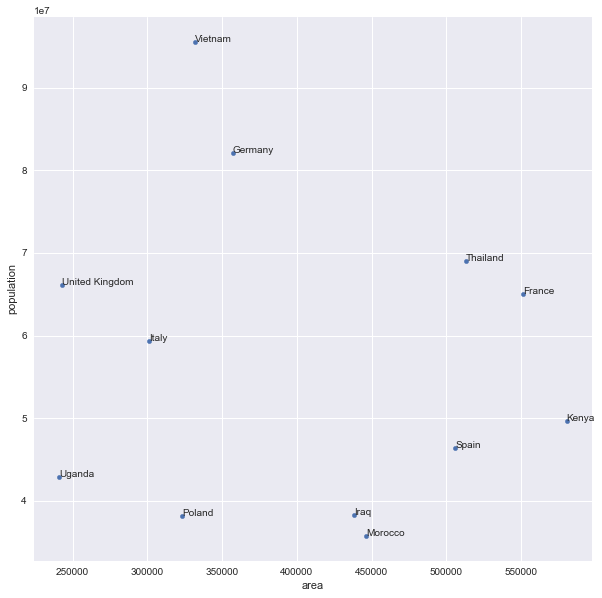

In [5]:
fig, ax = plt.subplots()
df_small.plot(
    x='area',
    y='population',
    figsize=(10, 10),
    kind='scatter', ax=ax)

for k, v in df_small.iterrows():
    ax.annotate(k, v)

fig.canvas.draw()

# 2. Model
####  Euclidean distance

$$d(x,y)\ =\ \sqrt{\sum\limits_{i=1}^{N}(x_i\ -\ y_i)^2}$$

In [6]:
def euclidean_distance(x: (int, int), y: (int, int)) -> int:
    '''
    Note: cast the result into an int which makes it easier to compare
    '''
    x1, x2 = x
    y1, y2 = y

    result = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    return int(round(result, 0))

#### Finding similar countries based on population and area

In [7]:
from collections import defaultdict

similar_countries = defaultdict(list)

for country in df.iterrows():
    name = country[0]
    area = country[1]['area']
    population = country[1]['population']
    
    for other_country in df.iterrows():
        other_name = other_country[0]
        other_area = other_country[1]['area']
        other_population = other_country[1]['population']
        
        if other_name == name: continue
        
        x = (area, other_area)
        y = (population, other_population)
        similar_countries[name].append(
            (euclidean_distance(x, y), other_name))

for country in similar_countries.keys():
    similar_countries[country].sort(key=lambda x: x[0], reverse=True)

In [8]:
# List of Vietnam similar countries based on population and area
similar_countries['Vietnam'][:10]

[(1314009093, 'China'),
 (1243642839, 'India'),
 (229096766, 'United States'),
 (168457922, 'Indonesia'),
 (114043793, 'Brazil'),
 (101476218, 'Pakistan'),
 (95541326, 'Pitcairn'),
 (95540776, 'Cocos (Keeling) Islands'),
 (95540376, 'Holy See (Vatican City State)'),
 (95540076, 'Tokelau')]

In [9]:
# List of Singapore similar countries based on population and area
similar_countries['Singapore'][:10]

[(1403841188, 'China'),
 (1333475333, 'India'),
 (318888101, 'United States'),
 (258289552, 'Indonesia'),
 (203758763, 'Brazil'),
 (191308765, 'Pakistan'),
 (185179768, 'Nigeria'),
 (158960972, 'Bangladesh'),
 (139331110, 'Russian Federation'),
 (123469951, 'Mexico')]